In [1]:
from qiskit import *
import numpy as np
import pylab as pl
import networkx as nx
from qiskit.visualization import *
from qaoa import *
from maxkcut import *

from matplotlib import rc
font = {'size' : 16}
rc('font', **font);
rc('text', usetex=True)

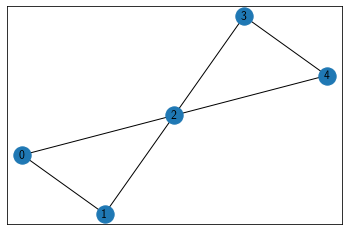

In [2]:
V = np.arange(0,5,1)
E = [(0,1,1.0),(0,2,1.0),(1,2,1.0),(3,2,1.0),(3,4,1.0),(4,2,1.0)] 

G = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

pos = nx.spring_layout(G)
nx.draw_networkx(G,pos=pos)
k_cuts=2

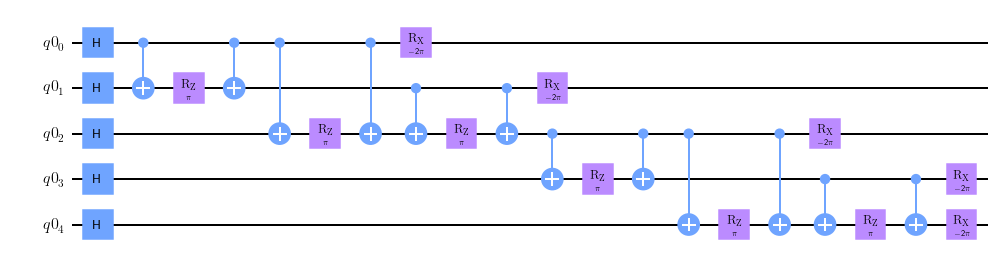

In [3]:
depth=1
options={}
options['G']=G
options['k_cuts']=k_cuts
cc=createCircuit_MaxCut(np.array((np.pi,np.pi)),depth, options)
cc.remove_final_measurements()
cc.draw(output='mpl')

In [4]:
Aer.backends()
backend_sim = Aer.get_backend('qasm_simulator')
backend_sv = Aer.get_backend('statevector_simulator')

In [5]:
def get_targetcost(gamma,beta):
    options={}
    options['G']=G
    options['k_cuts']=k_cuts
    cc=createCircuit_MaxCut(np.array((gamma,beta)),1, options)
#     cc.remove_final_measurements()
    job = execute(cc, backend_sim,shots=2**14)
    El,_,_ = measurementStatistics_MaxCut(job.result().results, options=options)
    return El

In [6]:
get_targetcost(0.1,0.2)

[3.2236328125]

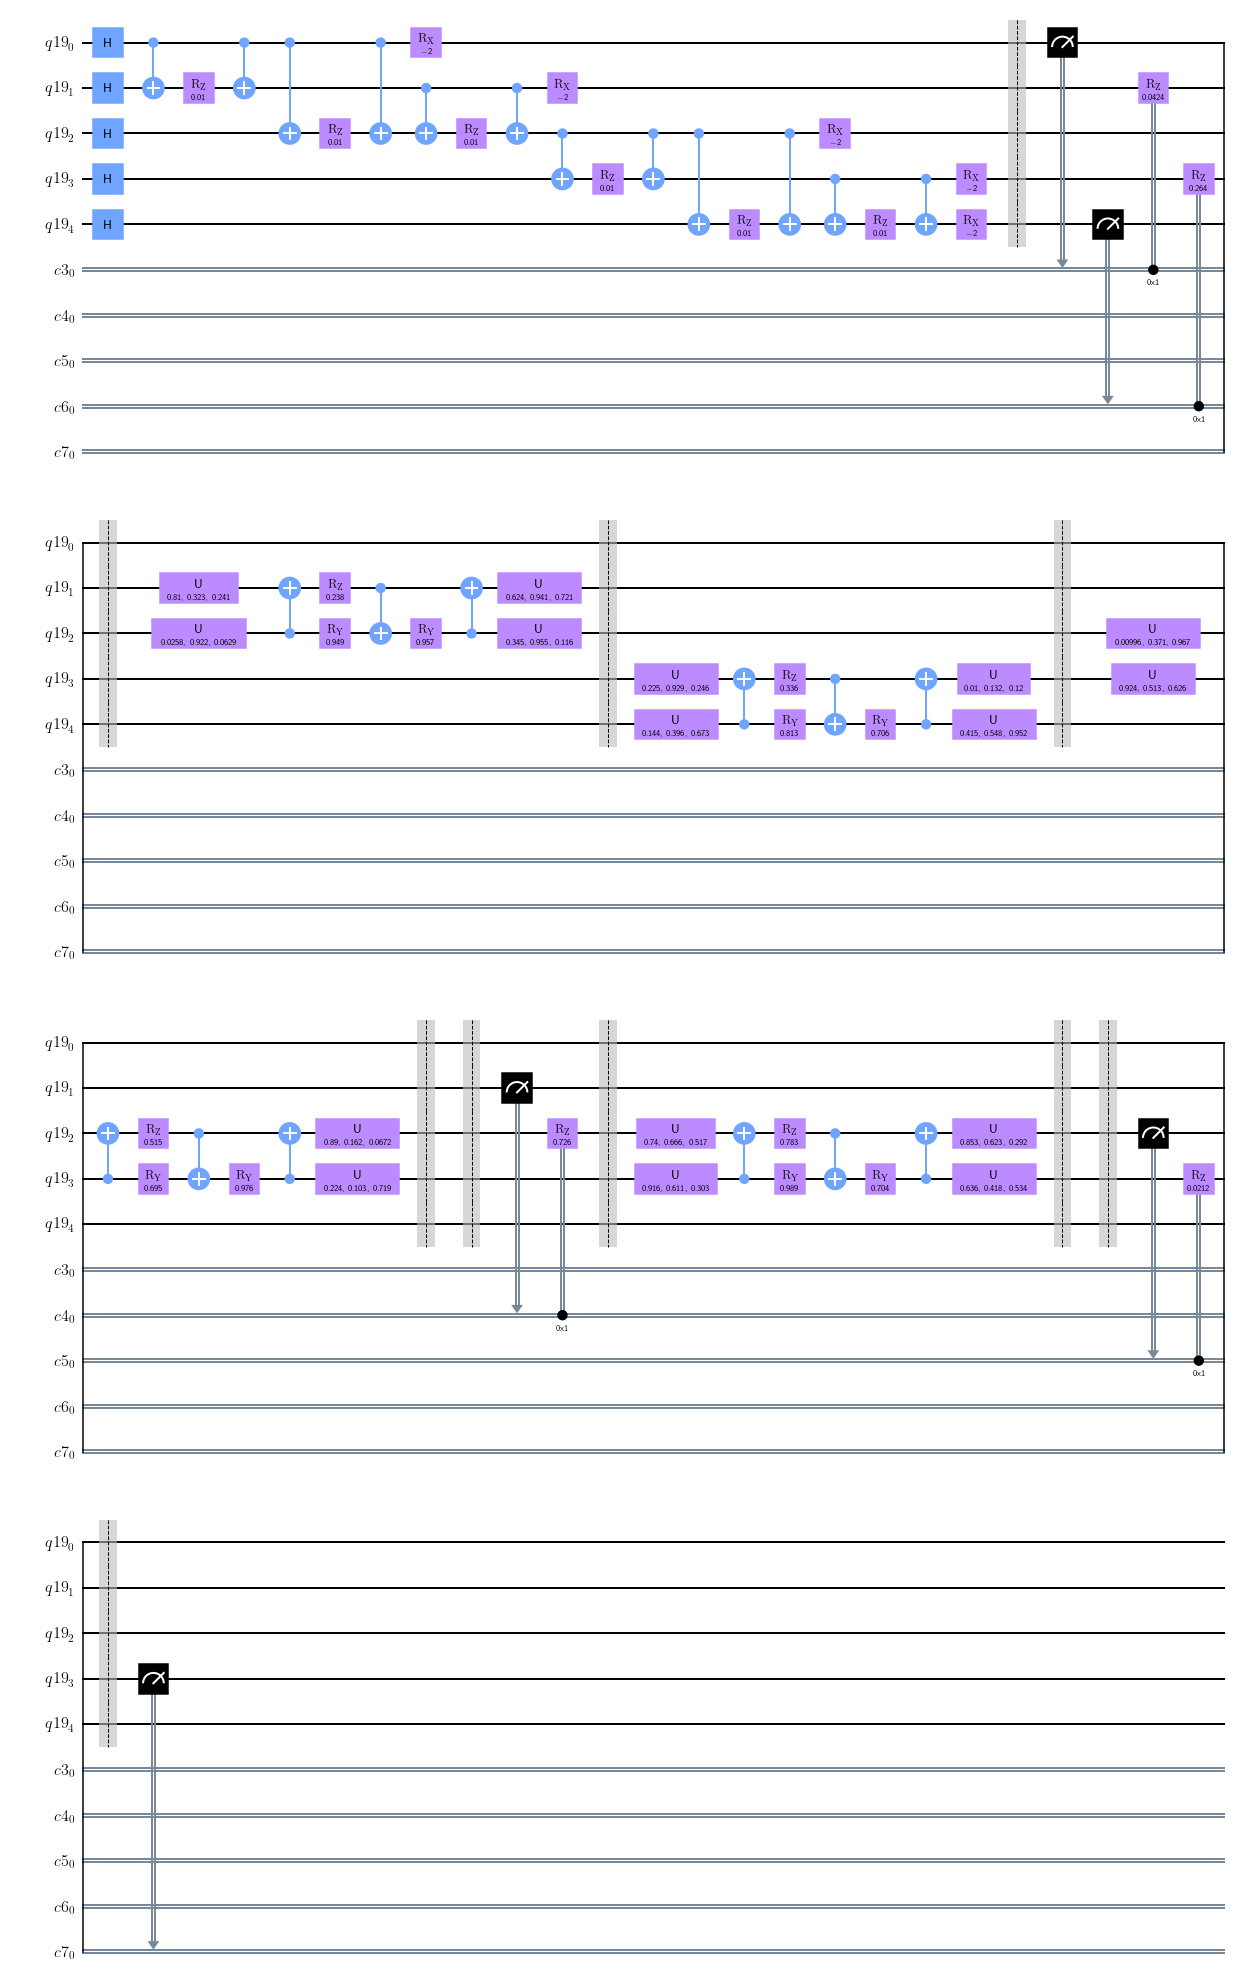

In [7]:
def addW(circuit, theta, ind, theta_ind_start):
    t=theta_ind_start
    qr=circuit.qregs[0]
    circuit.barrier()
    circuit.u(theta[t],theta[t+1],theta[t+2],qr[ind[0]])
    circuit.u(theta[t+3],theta[t+4],theta[t+5],qr[ind[1]])
    circuit.cx(qr[ind[1]],qr[ind[0]])
    circuit.rz(theta[t+6],qr[ind[0]])
    circuit.ry(theta[t+7],qr[ind[1]])
    circuit.cx(qr[ind[0]],qr[ind[1]])
    circuit.ry(theta[t+8],qr[ind[1]])
    circuit.cx(qr[ind[1]],qr[ind[0]])
    circuit.u(theta[t+9],theta[t+10],theta[t+11],qr[ind[0]])
    circuit.u(theta[t+12],theta[t+13],theta[t+14],qr[ind[1]])

    return circuit
    

def addQML(circuit, theta):
    qr=circuit.qregs[0]
#     cr=circuit.cregs[0]
    
    c = [ ClassicalRegister(1) for _ in range(qr.size) ]
    for register in c:
        circuit.add_register( register )
    
    circuit.barrier()
    circuit.measure(qr[0],c[0])
    circuit.rz(theta[0], qr[1]).c_if(c[0],1)
    circuit.measure(qr[4],c[3])
    circuit.rz(theta[1], qr[3]).c_if(c[3],1)
    usedparams=2
    circuit = addW(circuit,theta,[1,2],usedparams)
    usedparams+=15
    circuit = addW(circuit,theta,[3,4],usedparams)
    usedparams+=15
    circuit = addW(circuit,theta,[2,3],usedparams)
    usedparams+=15
    circuit.barrier()

    circuit.barrier()
    circuit.measure(qr[1],c[1])
    circuit.rz(theta[usedparams], qr[2]).c_if(c[1],1)
    usedparams+=1
    circuit = addW(circuit,theta,[2,3],usedparams)
    usedparams+=15
    circuit.barrier()
    
    circuit.barrier()
    circuit.measure(qr[2],c[2])
    circuit.rz(theta[usedparams], qr[3]).c_if(c[2],1)
    circuit.barrier()
    
    
    circuit.measure(qr[3],c[4])
    
    return circuit
    
cc =createCircuit_MaxCut(np.array((0.01,1.)),1, options)
cc.remove_final_measurements()
# display(cc.qregs[0],cc.cregs[0])

cc = addQML(cc,np.random.rand(100))
cc.draw(output='mpl',cregbundle=False)

# job = execute(cc, backend_sim,shots=2**14)
# job.result()

In [8]:
def measurementStatistics_qmlcost(experiment_results):

    expectations = []
    variances = []
    for result in experiment_results:
        n_shots = result.shots
        counts = result.data.counts

        E = 0
        E2 = 0
        for hexkey in list(counts.keys()):
            count = counts[hexkey]
            binstring = "{0:b}".format(int(hexkey,0)).zfill(5)
            if binstring[0]=='1':
                E += count/n_shots;
                E2 += count/n_shots;

        if n_shots == 1:
            v = 0
        else:
            v = (E2-E**2)*n_shots/(n_shots-1)
        expectations.append(E)
        variances.append(v)
    return expectations, variances

In [9]:
def get_qmlcost(gamma,beta,theta):
    options={}
    options['G']=G
    options['k_cuts']=k_cuts
    cc=createCircuit_MaxCut(np.array((gamma,beta)),1, options)
    cc.remove_final_measurements()
    cc = addQML(cc,theta)
    job = execute(cc, backend_sim,shots=2**14)
    e,v=measurementStatistics_qmlcost(job.result().results)
    return e,v,job

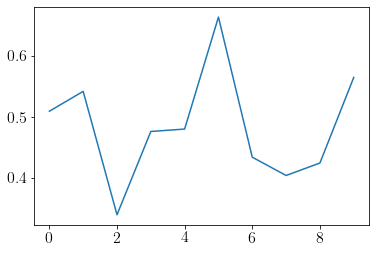

In [10]:
n=10
a=np.zeros(n)
for i in range(n):
    e,v,job=get_qmlcost(0.6,0.6, np.pi*np.random.rand(100))
    a[i]=e[0]
    # plot_histogram(job.result().get_counts())
pl.plot(a)